# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score
from kneed import KneeLocator

DATA_DIR = 'data'

## Task 0: Research Question

**Research question:**
*Can we identify different student profiles based on their behaviors and understand how these profiles relate to academic performance?*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

### A) Student Activity (Inputs):

##### 1) Student Activity Cleaning:

**Approach:**

We will begin by loading the `activity` dataset and processing it as follows:

- Cast columns to appropriate data types (e.g., convert to datetime formats)  
- Remove entries with missing `activity_completed` values or inconsistent timestamps (e.g., when completion occurs before the activity starts)  
- Remove entries where the activity duration exceeds 24 hours, as these likely indicate inactivity (e.g., students leaving the activity open)

In [2]:
# Load the data
activity = pd.read_csv(f'{DATA_DIR}/activity.csv')
activity_sizes = {'Original': len(activity)}

# Cast timestamps to datetime
activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

# Remove entries where the activity_completed was before the activity_started
activity = activity[activity['activity_completed'] > activity['activity_started']]
activity_sizes['After removing missing or inconcistent completion'] = len(activity)

# Create a column with the duration of the activity
activity['activity_duration'] = activity['activity_completed'] - activity['activity_started']
activity['activity_duration_minutes'] = activity['activity_duration'].dt.total_seconds() / 60

# Remove entries where the activity_completed is more than 24 hours after the activity_started
activity = activity[activity['activity_duration_minutes'] <= 24 * 60]
activity_sizes['After removing duration > 24h'] = len(activity)

In addition to removing entries where the activity duration exceeds 24 hours, we will also eliminate remaining outliers using the IQR method, as it is still unlikely that a student would spend several hours on a single activity. The IQR method provides a statistically grounded threshold for identifying such outliers, removing the need to define a manual cutoff.

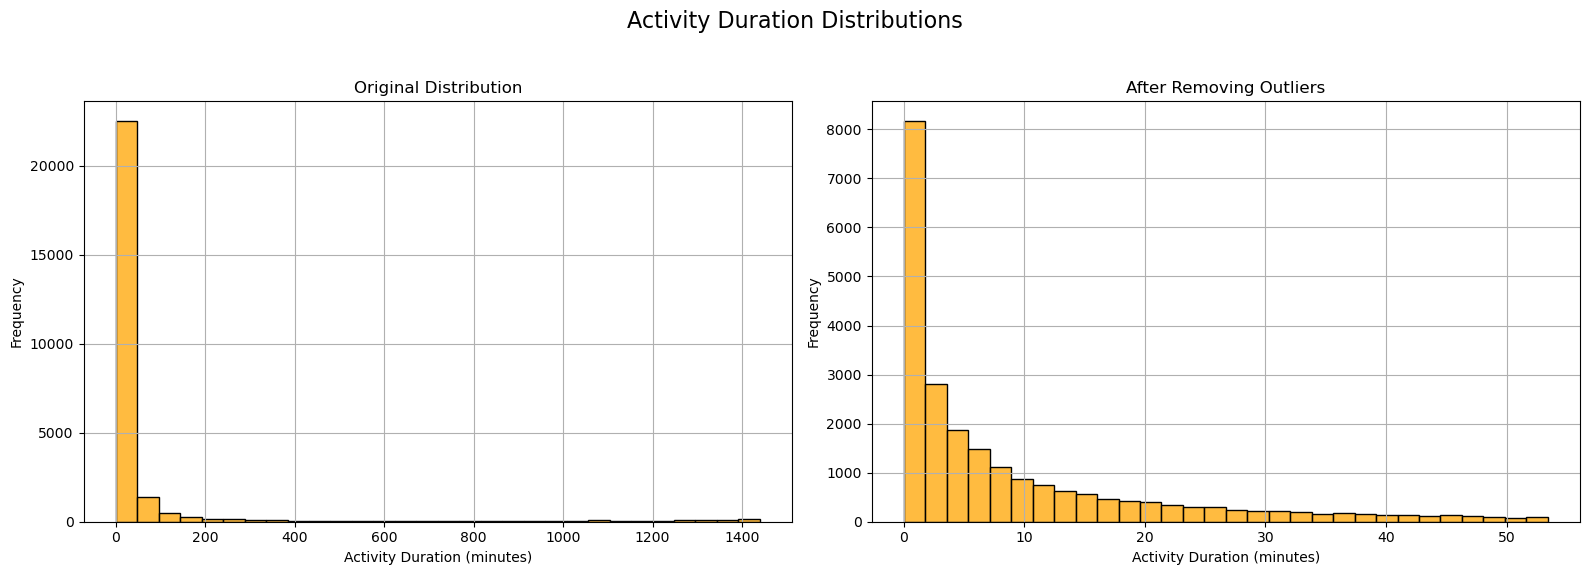

In [3]:
# Compute IQR bounds for filtering
Q1 = activity['activity_duration_minutes'].quantile(0.25)
Q3 = activity['activity_duration_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Activity Duration Distributions", fontsize=16)

# Before filtering
sns.histplot(activity['activity_duration_minutes'], bins=30, color='orange', ax=axes[0])
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('Activity Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].grid()

# Filter outliers
activity = activity[
    (activity['activity_duration_minutes'] >= lower_bound) &
    (activity['activity_duration_minutes'] <= upper_bound)
]
activity_sizes['After removing remaining outliers'] = len(activity)

# After filtering
sns.histplot(activity['activity_duration_minutes'], bins=30, color='orange', ax=axes[1])
axes[1].set_title('After Removing Outliers')
axes[1].set_xlabel('Activity Duration (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [4]:
# Dataset evolution
print("Data set sizes at each stage:")
for stage, size in activity_sizes.items():
    print(f"- {stage}: {size} entries ({size / activity_sizes['Original'] * 100:.2f}%)")


Data set sizes at each stage:
- Original: 72897 entries (100.00%)
- After removing missing or inconcistent completion: 38881 entries (53.34%)
- After removing duration > 24h: 26217 entries (35.96%)
- After removing remaining outliers: 22754 entries (31.21%)


**Observation:**

We observe that before applying the IQR method to filter out remaining outliers, the distribution of activity duration is right-skewed, with numerous extreme values reaching up to 1,400 mins (≈ 23 hours).

After removing these outliers, the distribution remains right-skewed (likely an exponential distribution), with durations ranging from 0 minutes to 1 hour.

Empirically, we found that the IQR method performs more effectively when applied after first removing entries with durations exceeding 24 hours, rather than relying on it alone.

After applying all filters, we are left with about 31% of the original dataset (22,754 entries). The most significant reduction occurs when removing entries with missing or inconsistent completion times, which alone reduces the dataset from 100% to 53%.  

One possible solution to retain more data would be to predict the missing completion times. However, this could compromise the reliability of the analysis by introducing less representative user behavior. Therefore, we chose to leave this as a potential direction for future work, if necessary.

##### 2) Student Feature Creation:

We will now compute a set of features for each student to enable clustering and identify different profiles. The final dataframe should contain one row per student, with columns summarizing their activity.

In [22]:
user_daily_activity = activity.copy(deep=True)

# Create new column for activity started day
user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

# Compute gaps between active days for each user
user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

# Keep only relevnt columns
columns = ['user_id', 'active_day', 'gap_days']
user_daily_activity = user_daily_activity[columns]

# Compute the median of gap_days per user
user_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
user_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)

# Add the number of active days of that user (count)
user_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values

# Add the median activity duration of that user (activity_completed - activity_started) only when activity_completed is not missing
user_activity['median_activity_duration'] = activity.groupby('user_id').apply(
    lambda x: (x['activity_completed'] - x['activity_started']).median()
).reset_index(drop=True)

# Add the number of activities of that user (count)
user_activity['activities_count'] = activity.groupby('user_id')['activity_id'].count().values
# Add the number of unique activity types of that user
user_activity['activity_types_count'] = activity.groupby('user_id')['activity_type'].nunique().values

# Convert timedelta to minutes
user_activity['median_activity_duration_minutes'] = user_activity['median_activity_duration'].dt.total_seconds() / 60

# Drop the original timedelta column
user_activity.drop(columns=['median_activity_duration'], inplace=True)

print("Activity per User:")
display(user_activity.head())
print("Shape:", user_activity.shape)


Activity per User:


/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_77753/2776266635.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_activity['median_activity_duration'] = activity.groupby('user_id').apply(


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes
0,1,4.0,11,19,2,4.716667
1,4,7.5,7,31,1,2.266667
2,6,7.0,9,30,2,7.658333
3,7,4.0,16,30,2,13.583333
4,9,12.0,8,26,2,6.466667


Shape: (843, 6)


We now have our `user_activity` (input) dataframe, where each row corresponds to a student and includes their activity features. Their descriptions and distributions will be discussed later in Task 1.C.

### B) Student Scores (Outputs):

**Approach:**

We will begin by loading the `all_scores` dataset and processing it as follows:

- Cast columns to appropriate data types (e.g., convert to datetime formats)
- Aggregate the scores for each student by computing the median of their scores
- Remove outliers

In [6]:
# Load the data
all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

# Cast timestamps to datetime
all_scores['time'] = pd.to_datetime(all_scores['time'], unit='s')

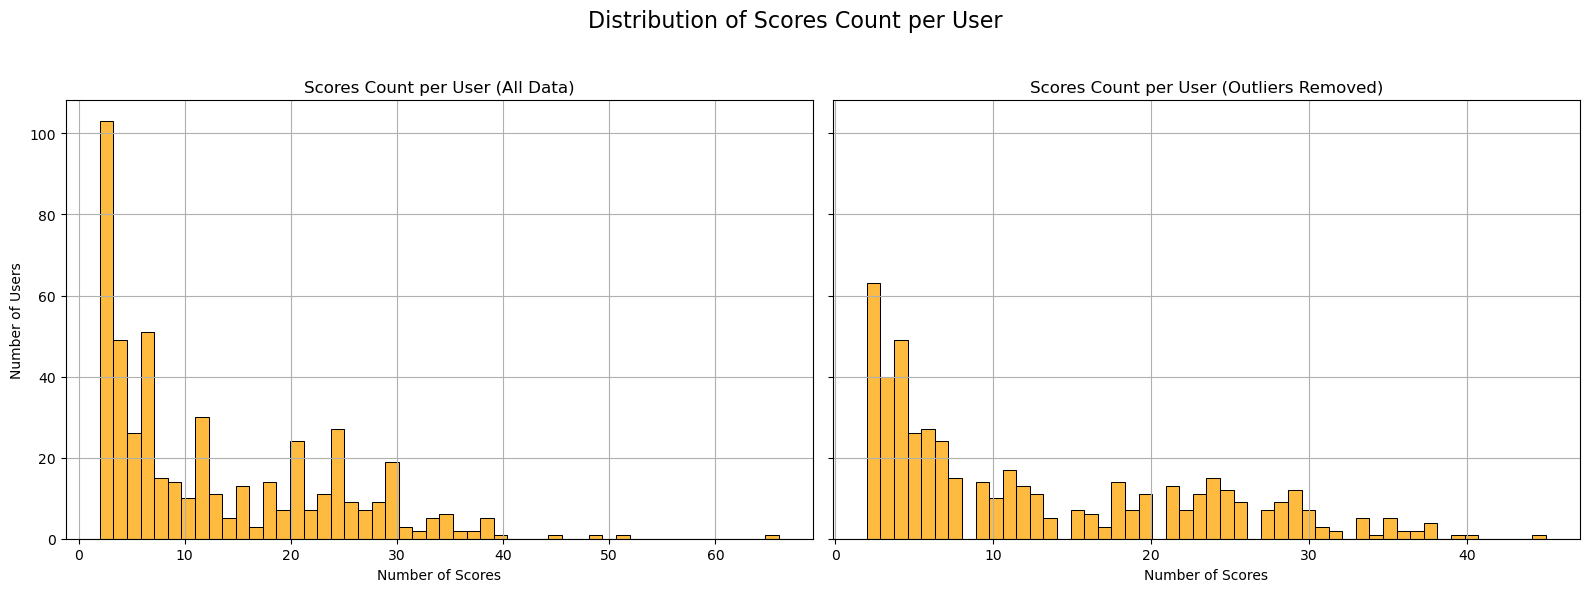

Number of users before outlier removal: 494
Number of users after outlier removal: 491 (99.39%)


In [7]:
# Compute median and count of scores per user
students_median_score = all_scores.groupby('user_id')['percentage'].median().reset_index()
students_median_score.rename(columns={'percentage': 'median_score'}, inplace=True)
students_median_score['scores_count'] = all_scores.groupby('user_id')['percentage'].count().values

# Remove users with less than 1 score
students_median_score = students_median_score[students_median_score['scores_count'] > 1]

# Plot 1: Original distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.histplot(students_median_score['scores_count'], bins=50, ax=axes[0], color='orange')
axes[0].set_title('Scores Count per User (All Data)')
axes[0].set_xlabel('Number of Scores')
axes[0].set_ylabel('Number of Users')
axes[0].grid()

# IQR Outlier Removal (in-place on df)
Q1 = students_median_score['scores_count'].quantile(0.25)
Q3 = students_median_score['scores_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter in-place
length_before = len(students_median_score)
students_median_score = students_median_score[(students_median_score['scores_count'] >= lower_bound) & (students_median_score['scores_count'] <= upper_bound)]
length_after = len(students_median_score)

# Plot 2: After outlier removal
sns.histplot(students_median_score['scores_count'], bins=50, ax=axes[1], color='orange')
axes[1].set_title('Scores Count per User (Outliers Removed)')
axes[1].set_xlabel('Number of Scores')
axes[1].grid()

plt.suptitle('Distribution of Scores Count per User', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"Number of users before outlier removal: {length_before}")
print(f"Number of users after outlier removal: {length_after} ({length_after / length_before * 100:.2f}%)")

Once again, we removed outlier students (those with very few or very many entries) using the IQR method. This helps eliminate bias from users who participated only once, as well as those who were unusually active and not representative of the majority. In both cases, the distributions are right-skewed.

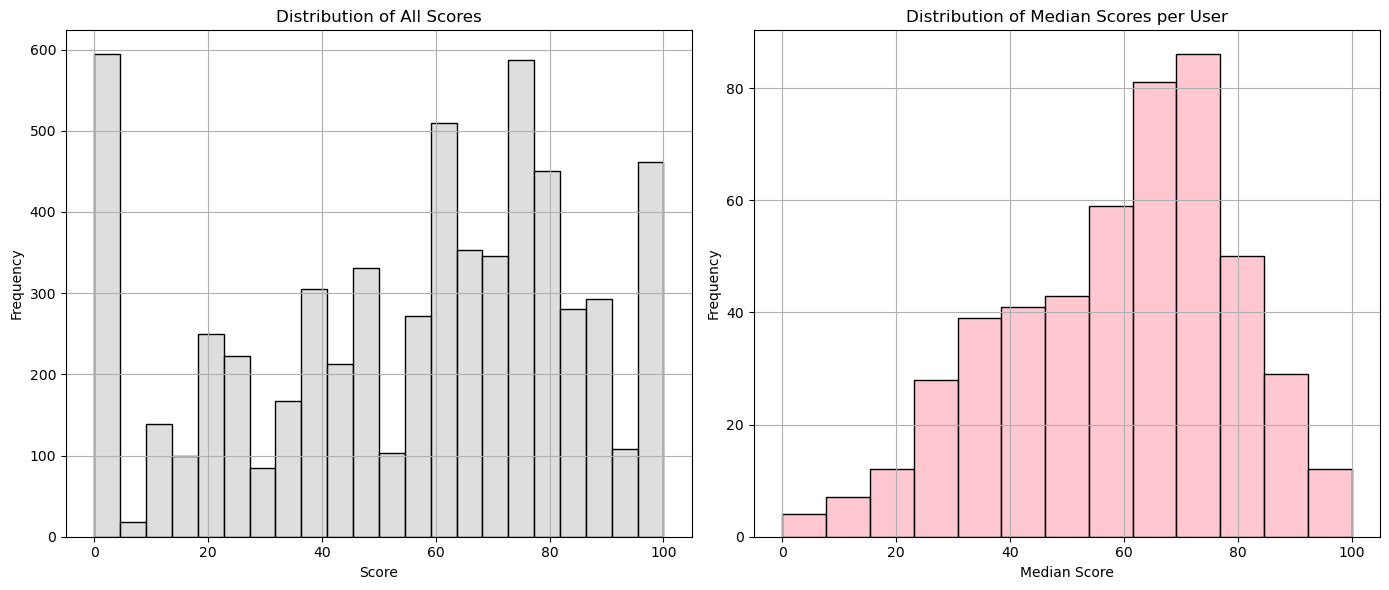

In [8]:
# Apply the outlier removal to the all_scores dataframe
all_scores = all_scores[all_scores['user_id'].isin(students_median_score['user_id'])]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Distribution of all individual scores
sns.histplot(all_scores['percentage'], color='lightgrey', ax=axes[0])
axes[0].set_title('Distribution of All Scores')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Right: Distribution of median scores per user
sns.histplot(students_median_score['median_score'], color='lightpink', ax=axes[1])
axes[1].set_title('Distribution of Median Scores per User')
axes[1].set_xlabel('Median Score')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Observation:**

The chart on the left shows the distribution of all individual scores. We observe a noisy Gaussian-like distribution with two unusual peaks at 0 and 100. One possible explanation is that the scores are expressed as percentages, and exercises graded out of 1 point can result only in 0% or 100%.

On the right, we see the distribution of each student's median score, which follows a normal distribution centered around 75%. Notably, the sharp peaks at 0 and 100 disappear after aggregating by student. This is likely due to the use of the median, which is less sensitive to outliers than the mean.

From this point onward, we will consider only the median score per user (i.e., the overall user grade), as shown in the chart on the right.

### C) All-in-All (Inputs + Outputs)

In [9]:
# Create a final dataframe with user activity and scores
students = user_activity.merge(
    students_median_score,
    how='inner',
    left_on='user_id',
    right_on='user_id'
)

# Print number of users
print(f"Number of users in user_activity: {user_activity['user_id'].nunique()}")
print(f"Number of users in students_median_score: {students_median_score['user_id'].nunique()}")
print(f"Number of users after merging: {students['user_id'].nunique()}")

display(students.head())

Number of users in user_activity: 843
Number of users in students_median_score: 491
Number of users after merging: 472


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,median_score,scores_count
0,1,4.0,11,19,2,4.716667,59.147059,2
1,4,7.5,7,31,1,2.266667,71.000000,3
2,6,7.0,9,30,2,7.658333,57.275000,14
3,7,4.0,16,30,2,13.583333,74.000000,5
4,9,12.0,8,26,2,6.466667,50.000000,5


We end up with a final `students` dataset containing 472 students, which closely matches the size of the scores dataset (96% overlap). Let's visualize the distribution of each feature.

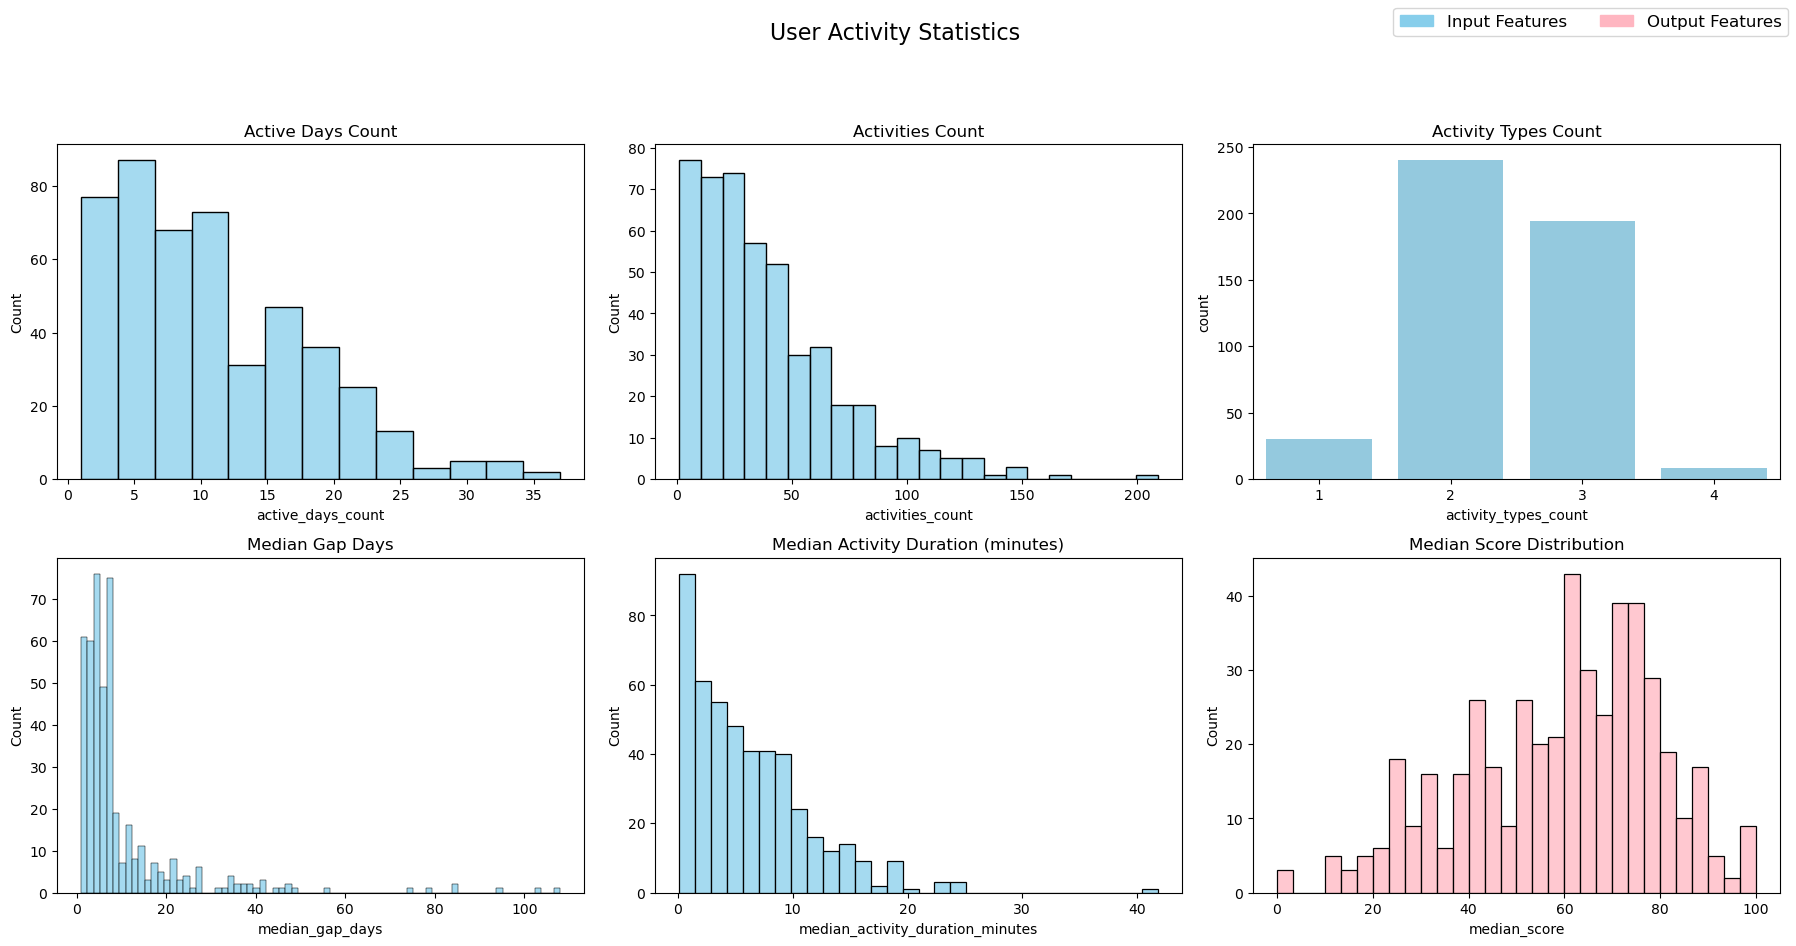

In [24]:
# Plot each column in a suitable seaborn chart using a single figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("User Activity Statistics", fontsize=16)

# Histogram for active_days_count
sns.histplot(students['active_days_count'], ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Active Days Count')

# Histogram for activities_count
sns.histplot(students['activities_count'], ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Activities Count')

# Countplot for activity_types_count
sns.countplot(x=students['activity_types_count'], ax=axes[0, 2], color='skyblue')
axes[0, 2].set_title('Activity Types Count')

# Histogram for median_gap_days
sns.histplot(students['median_gap_days'], ax=axes[1, 0], color='skyblue')
axes[1, 0].set_title('Median Gap Days')

# Histogram for median_activity_duration_minutes
sns.histplot(students['median_activity_duration_minutes'], ax=axes[1, 1], bins=30, color='skyblue')
axes[1, 1].set_title('Median Activity Duration (minutes)')

# Histogram for median_score
sns.histplot(students['median_score'], ax=axes[1, 2], bins=30, color='lightpink')
axes[1, 2].set_title('Median Score Distribution')

# Add legend
input_patch = Patch(color='skyblue', label='Input Features')
output_patch = Patch(color='lightpink', label='Output Features')
fig.legend(handles=[input_patch, output_patch], loc='upper right', ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 0.93])
plt.show()

**Students Clustering Features (Inputs):**

- `user_id`: The unique identifier of the student.
- `active_days_count`: The number of days the student has been active since registering.  
- `activities_count`: The total number of activities the student has completed since registration. _Right-skewed distribution, likely an exponential distribution._
- `activity_types_count`: The number of distinct activity types the student has engaged in since registration, indicating whether they focus on a few types or use the app for various learning purposes. _Gaussian distribution_
- `median_gap_days`: The median number of days between consecutive login days for the student. _Right-skewed distribution, likely an exponential distribution._
- `median_activity_duration_minutes`: The median duration, in minutes, of the student's activities. _Right-skewed distribution, likely an exponential distribution._

**Students Score (Output):**
- `median_score`: The median of all the scores the student has received. _Gaussian distribution_


## Task 2: Model Building

Train a model for your research question. 

### A) Profiles Creation (Student Clustering):

We will create clusters of students to better understand the different learner profiles. To achieve this, we will use an unsupervised learning approach with K-Means clustering.

The key hyperparameters we will determine are:

- **Features used for clustering:** Determined through correlation analysis and machine learning coefficient interpretation.
- **Number of clusters (K):** Determined using the Elbow method  

##### 1) Hyperparameter Tuning of Clustering Features:

**Approach:**

- **Corralation Analysis:** As observed in Task A.C, the scores follow a Gaussian distribution. However, the input features are highly right-skewed and appear to follow an exponential distribution. Therefore, we will use Spearman correlation instead of Pearson, as the latter is only appropriate for normally distributed data.

- **Machine Learning Coefficient Interpretation:** We will use a linear regression model to interpret the coefficients and understand which features are most strongly associated with the output. Since the goal is interpretation rather than prediction, we will train the model on the full dataset without splitting it into training and evaluation sets. However, to ensure robustness, we will perform cross-validation and average the coefficient weights across folds.

In [11]:
# Define the candidate features for clustering
candidate_features = [
    'median_gap_days',
    'active_days_count',
    'activities_count',
    'activity_types_count',
    'median_activity_duration_minutes'
]

# Define the target variable
target = 'median_score'

# Drop entries with missing values in the candidate features and target (necessary for models)
students_no_nan = students.dropna(subset=candidate_features + [target], inplace=False)

# Print number of entries after dropping NaN values, and percentage of entries kept
print(f"Number of entries after dropping NaN values: {students_no_nan.shape[0]}")
print(f"Percentage of entries kept: {students_no_nan.shape[0] / students.shape[0] * 100:.2f}%")

Number of entries after dropping NaN values: 451
Percentage of entries kept: 95.55%


In [12]:
# Approach 1: Spearman correlation
correlations = []
p_values = []
for feature in candidate_features:
    data_pair = students_no_nan[[feature, target]]
    corr, p_val = spearmanr(data_pair[feature], data_pair[target])
    correlations.append(corr)
    p_values.append(p_val)

In [ ]:
# Approach 2: Linear regression coefficients
X = students_no_nan[candidate_features]
y = students_no_nan[target]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Model (defined once)
model = LinearRegression()

# Store per-fold results
all_coefs = []
r2_scores = []
mae_scores = []
rmse_scores = []

# Cross-validation loop
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    all_coefs.append(model.coef_)
    
    y_pred = model.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Final outputs
weights = np.mean(all_coefs, axis=0)


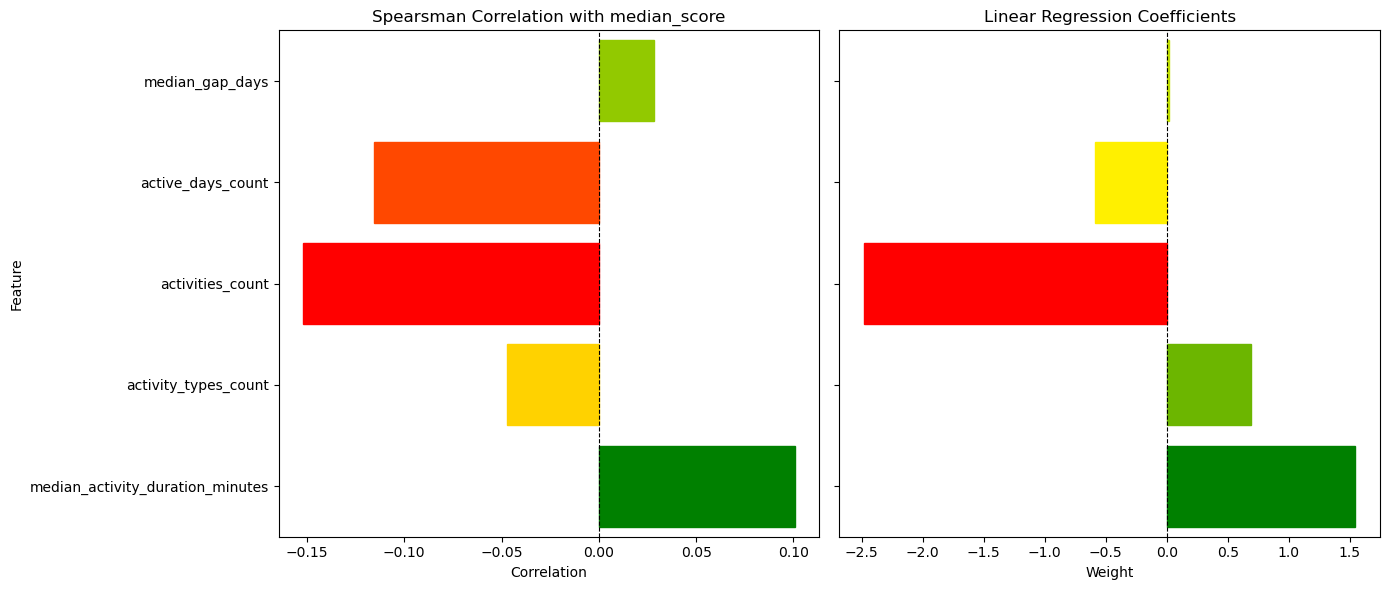

In [14]:
# Combine into DataFrame
combined_df = pd.DataFrame({
    'feature': candidate_features,
    'spearsman_correlation': correlations,
    'linear_regression_coeff': weights
})

# Custom red-to-green gradient
custom_cmap = LinearSegmentedColormap.from_list("custom_red_green", ["red", "yellow", "green"])
norm_corr = Normalize(vmin=min(correlations), vmax=max(correlations))
norm_weight = Normalize(vmin=min(weights), vmax=max(weights))

# Handle colors
corr_colors = [custom_cmap(norm_corr(val)) for val in correlations]
weight_colors = [custom_cmap(norm_weight(val)) for val in weights]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Correlation barplot
bars_corr = sns.barplot(x='spearsman_correlation', y='feature', data=combined_df, ax=axes[0], color='gray')
for bar, color in zip(bars_corr.patches, corr_colors):
    bar.set_color(color)
axes[0].axvline(0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_title('Spearsman Correlation with median_score')
axes[0].set_xlabel('Correlation')
axes[0].set_ylabel('Feature')

# Linear regression barplot
bars_weight = sns.barplot(x='linear_regression_coeff', y='feature', data=combined_df, ax=axes[1], color='gray')
for bar, color in zip(bars_weight.patches, weight_colors):
    bar.set_color(color)
axes[1].axvline(0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_title('Linear Regression Coefficients')
axes[1].set_xlabel('Weight')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


**Observation:**

Overall, the Spearman correlation analysis and the linear regression coefficients show consistent patterns across most features. For instance, both methods indicate a strong negative relationship between `activities_count` and the median score, and a positive association between `median_activity_duration_minutes` and the score. This suggests that longer activity sessions are generally linked with better performance, while simply doing a high number of activities is correlated with lower scores.

However, there are some counterintuitive findings. One example is `median_gap_days`, which shows a slightly positive correlation with the score in the Spearman analysis. This is surprising, as better scores are usually expected to be associated with more frequent (i.e., less spaced out) learning sessions.

**Conclusion:**

This analysis was intended to guide the selection of input features for clustering. However, given the presence of some unexpected relationships, we decided to **retain all features** and evaluate their impact on clustering performance in a later step.

##### 2) Hyperparameter Tuning of Number of Clusters (K):

**Approach:**

We will use K-Means clustering and determine the optimal number of clusters using the Elbow method. The Euclidean distance metric will be used, as it is well-suited for our data, where all features are numerical.

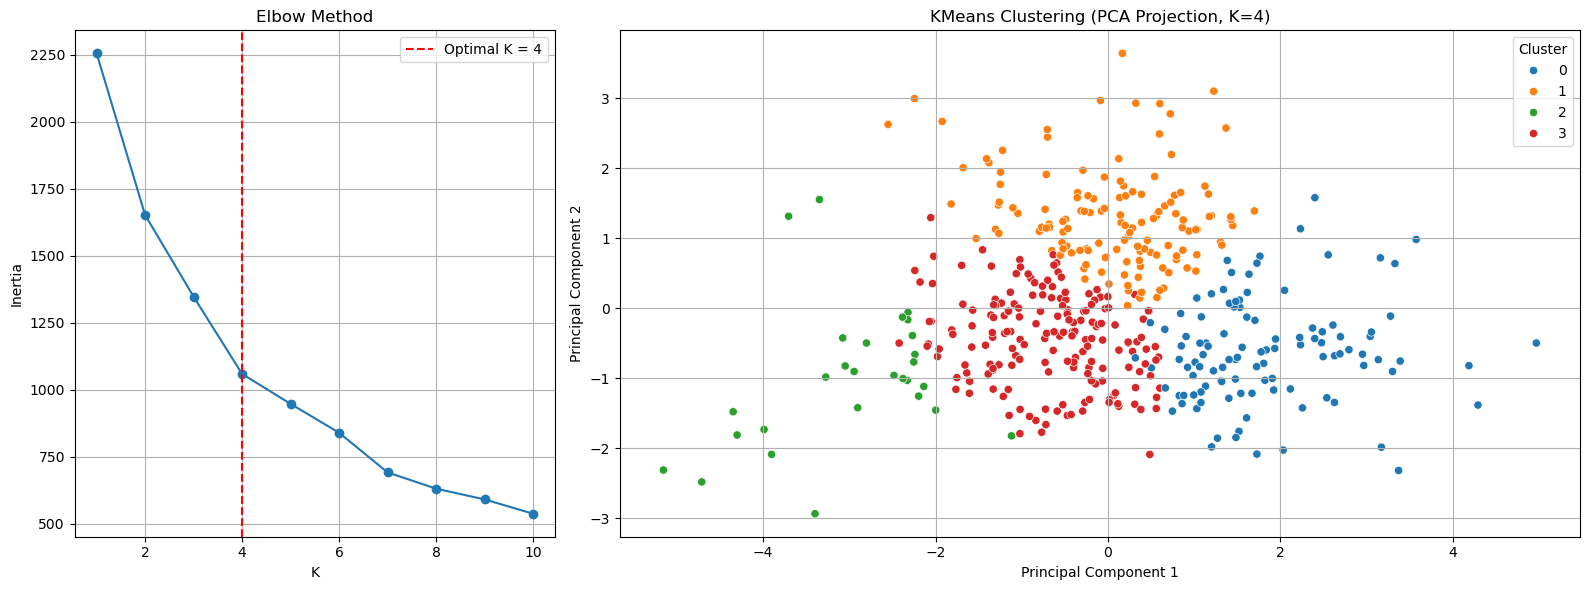

In [15]:
# Use all features for clustering
columns_used = candidate_features
X = students_no_nan[columns_used]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use Elbow method to find optimal K
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Select optimal K
knee = KneeLocator(K_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee.knee

# Apply KMeans with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
students_no_nan = students_no_nan.copy()
students_no_nan['cluster'] = kmeans.fit_predict(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 2]})

# Plot Elbow chart
axes[0].plot(K_range, inertia, marker='o')
axes[0].axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K = {optimal_k}')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Inertia')
axes[0].legend()
axes[0].grid(True)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to the DataFrame
students_projection_pca = students_no_nan.copy()
students_projection_pca['PCA1'] = X_pca[:, 0]
students_projection_pca['PCA2'] = X_pca[:, 1]

# Plot Cluster scatterplot using PCA components
sns.scatterplot(
    data=students_projection_pca,
    x='PCA1',
    y='PCA2',
    hue='cluster',
    palette='tab10',
    ax=axes[1]
)
axes[1].set_title(f"KMeans Clustering (PCA Projection, K={optimal_k})")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].legend(title='Cluster')
axes[1].grid(True)

plt.tight_layout()
plt.show()


**Observation:**

As shown in the chart on the left, we applied the Elbow method with K-Means to determine that the optimal number of clusters is **4**.

The chart on the right shows a PCA projection of the data onto two dimensions, with each point colored according to its assigned cluster. It is important to note that the clustering was performed in the original feature space. The 2D PCA projection is used only for visualization.

While this projection helps in visualizing the data structure, the clusters do not appear clearly separated in this 2D space. This suggests that the true cluster boundaries may lie in higher-dimensional space and are not easily distinguishable by eye in two dimensions.

### 3) Profiles Interpretation:

Now that we have our clusters, we will compare student scores across them by analyzing the median grade within each cluster. Specifically, we will compute the median of each feature across all students in each cluster. This aggregation approach helps reduce the impact of outliers and provides a more robust comparison.

Additionally, clusters will be ordered in decreasing order of their median score to facilitate interpretation.

In [ ]:
# Median feature values per cluster
cluster_values = students_no_nan.groupby('cluster')[columns_used].median().T

# Compute median score and user count per cluster
cluster_score_raw = students_no_nan.groupby('cluster').agg(
    median_score=('median_score', 'median'),
    users_count=('user_id', 'nunique')
)

# Sort clusters by decreasing median_score
sorted_clusters = cluster_score_raw.sort_values(by='median_score', ascending=False).index.tolist()
cluster_values = cluster_values[sorted_clusters]
cluster_score = cluster_score_raw.loc[sorted_clusters].T
new_columns = [f'Cluster {i+1}' for i in range(len(sorted_clusters))]
cluster_values.columns = new_columns
cluster_score.columns = new_columns

# Combine values + scores
cluster_values_df = pd.concat([cluster_values, cluster_score], axis=0)

# Display numeric summary
display(cluster_values_df)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
median_gap_days,41.500000,7.000000,6.000000,4.000000
active_days_count,3.000000,6.000000,14.000000,17.000000
activities_count,9.500000,21.500000,36.000000,79.500000
activity_types_count,2.000000,2.000000,2.000000,3.000000
median_activity_duration_minutes,3.825000,3.679167,11.016667,2.729167
median_score,72.382353,63.432206,62.500000,57.320000
users_count,28.000000,180.000000,135.000000,108.000000


**Interpretation and Visualization Approach:**

The features will be interpreted using simple, color-coded labels for easier readability. Users will be divided into three equally sized groups (low, medium, high) based on how their feature values compare to others.

In [ ]:
feature_display_names = {
    'median_gap_days': 'Usage Frequency',
    'active_days_count': 'Total Active Days',
    'activities_count': 'Total Activities',
    'activity_types_count': 'Activity Types',
    'median_activity_duration_minutes': 'Activity Duration',
    'median_score': 'Median Score',
    'users_count': 'Number of Students'
}

def create_interpretation_df(use_auto_colors, interpretation_labels, feature_to_corr=None, custom_cmap=None):
    # Rename cluster columns to "Profile {n+1}"
    profile_values = cluster_values.copy()
    profile_values.columns = [f'Profile {int(c.split()[-1]) + 1}' for c in profile_values.columns]
    
    interpretation_df = pd.DataFrame(index=profile_values.index, columns=profile_values.columns, dtype=object)

    for feature in interpretation_df.index:
        data = students_no_nan[feature]
        values = profile_values.loc[feature]

        if feature == 'median_gap_days':
            data = -data
            values = -values

        _, bins = pd.qcut(data, q=3, retbins=True, duplicates='drop')
        labels = interpretation_labels.get(feature, ['Low', 'Medium', 'High'])[:len(bins) - 1]

        for profile in profile_values.columns:
            bin_index = pd.cut([values[profile]], bins=bins, labels=range(len(labels)), include_lowest=True)[0]
            label_text = labels[int(bin_index)]

            if use_auto_colors:
                corr = feature_to_corr.get(feature, 0)
                if corr >= 0:
                    color = custom_cmap(int(bin_index) / 2)
                else:
                    reversed_bin = 2 - int(bin_index)
                    color = custom_cmap(reversed_bin / 2)
            else:
                color_map = {'Red': 'red', 'Yellow': 'orange', 'Green': 'green'}
                label_text, label_color = interpretation_labels[feature][int(bin_index)]
                color = color_map[label_color]

            interpretation_df.loc[feature, profile] = (label_text, color)

    interpretation_df.loc['median_score'] = [(f"{val:.1f}", None) for val in median_score_row]
    interpretation_df.loc['users_count'] = [(f"{int(val)}", None) for val in users_count_row]
    interpretation_df.index = interpretation_df.index.map(lambda f: feature_display_names.get(f, f))

    return interpretation_df

def plot_interpretation_table(ax, interpretation_df, title):
    sorted_profiles = median_score_row[interpretation_df.columns].sort_values(ascending=False).index.tolist()
    ordered_df = interpretation_df[sorted_profiles]
    student_counts = interpretation_df.loc["Number of Students"]
    student_counts = student_counts[sorted_profiles]
    col_headers = [f"Profile {i+1}\n({int(float(student_counts[col][0]))} students)" for i, col in enumerate(sorted_profiles)]

    display_df = ordered_df.drop(index="Number of Students")
    color_df = ordered_df.drop(index="Number of Students")
    display_df = display_df.map(lambda x: x[0] if isinstance(x, tuple) else x)

    ax.axis('off')
    table = ax.table(
        cellText=display_df.values,
        rowLabels=display_df.index,
        colLabels=col_headers,
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.8)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_height(0.18)
            continue
        row_label = display_df.index[row - 1]
        if row_label == "Median Score":
            cell.get_text().set_fontweight('bold')
            cell.get_text().set_color('black')
            continue
        value = color_df.iloc[row - 1, col]
        if isinstance(value, tuple) and value[1] is not None:
            cell.get_text().set_color(value[1])

    median_index = display_df.index.get_loc("Median Score") + 1
    row_label_cell = table[(median_index, -1)]
    row_label_cell.get_text().set_fontweight('bold')
    row_label_cell.get_text().set_color('black')

    for row in range(1, len(display_df.index) + 1):
        label_cell = table[(row, -1)]
        label_cell.get_text().set_color('black')

    ax.set_title(title)

# Setup
custom_cmap = LinearSegmentedColormap.from_list("custom_red_orange_green", ["red", "orange", "green"])
feature_to_corr = dict(zip(candidate_features, correlations))

# Manual interpretation labels
manual_labels = {
    'median_gap_days': [('Rarely', 'Red'), ('Occasionally', 'Yellow'), ('Frequently', 'Green')],
    'active_days_count': [('Low Activity', 'Red'), ('Moderate Activity', 'Yellow'), ('High Activity', 'Green')],
    'activities_count': [('Few Activities', 'Red'), ('Some Activities', 'Yellow'), ('Many Activities', 'Green')],
    'median_activity_duration_minutes': [('Short Duration', 'Red'), ('Moderate Duration', 'Yellow'), ('Long Duration', 'Green')],
    'activity_types_count': [('Narrow Focus', 'Red'), ('Moderate Variety', 'Yellow'), ('Diverse Activity', 'Green')],
}

# Auto interpretation labels
auto_labels = {
    'median_gap_days': ['Rarely', 'Occasionally', 'Frequently'],
    'active_days_count': ['Low Activity', 'Moderate Activity', 'High Activity'],
    'activities_count': ['Few Activities', 'Some Activities', 'Many Activities'],
    'median_activity_duration_minutes': ['Short Duration', 'Moderate Duration', 'Long Duration'],
    'activity_types_count': ['Narrow Focus', 'Moderate Variety', 'Diverse Activity'],
}

# Prepare shared cluster_score rows
adjusted_cluster_score = cluster_score.copy()
adjusted_cluster_score.columns = [f'Profile {int(c.split()[-1]) + 1}' for c in adjusted_cluster_score.columns]
median_score_row = adjusted_cluster_score.loc['median_score']
users_count_row = adjusted_cluster_score.loc['users_count']

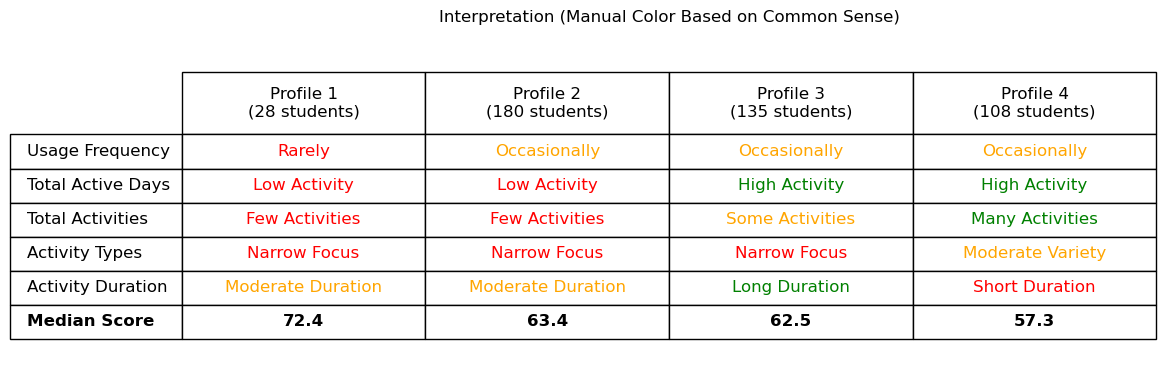

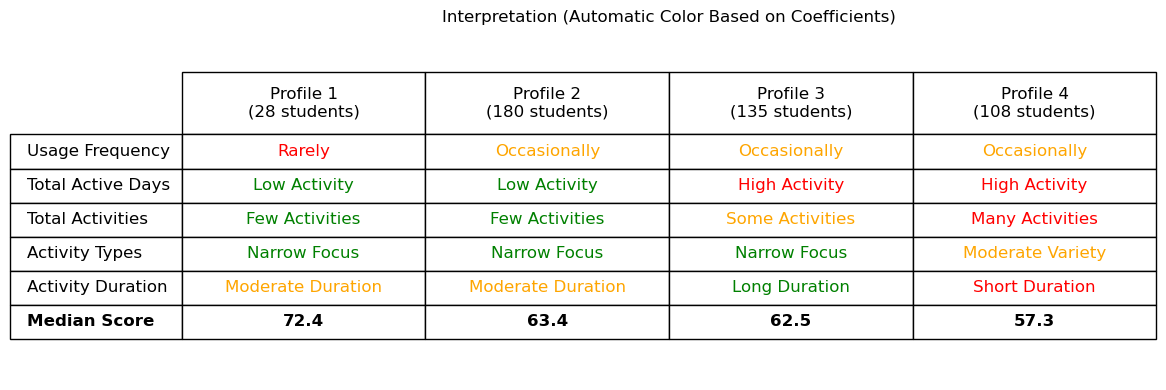

In [ ]:
# Create both interpretation DataFrames
manual_df = create_interpretation_df(False, manual_labels)
auto_df = create_interpretation_df(True, auto_labels, feature_to_corr, custom_cmap)

# Plot first table
fig1, ax1 = plt.subplots(figsize=(12, 4))
plot_interpretation_table(ax1, manual_df, "Interpretation (Manual Color Based on Common Sense)")
plt.tight_layout()
plt.show()

# Plot second table
fig2, ax2 = plt.subplots(figsize=(12, 4))
plot_interpretation_table(ax2, auto_df, "Interpretation (Automatic Color Based on Coefficients)")
plt.tight_layout()
plt.show()

**Conclusion:**

The four profiles identified through clustering exhibit different learning behaviors and corresponding academic performance, as reflected in their **median scores**.

- **Profile 1 (28 students)**: These students use the app **rarely**, with **low activity**, **few activity types**, and **moderate activity durations**. Despite their limited engagement, they achieve the **highest median score (72.4)**. This suggests that **focused, efficient study sessions** might be particularly effective.

- **Profile 2 (180 students)**: These students also show **low engagement** (few days and activities), with **narrow focus** and **moderate durations**. Their score is slightly lower at **63.4**, indicating a possible difference in study effectiveness compared to Profile 1.

- **Profile 3 (135 students)**: This group is **more active**, with **high usage frequency**, a **broader range of activities**, and **longer durations**, yet their median score is **62.5**. This might suggest that higher activity does not necessarily translate to higher performance, especially if it lacks focus.

- **Profile 4 (108 students)**: These students are also **highly active**, with **many activities** and **moderate variety**, but their **short session durations** are coupled with the **lowest median score (57.3)**. This implies that **short, scattered interactions** may be less effective for learning outcomes.

**Color Coding:**

- **Common Sense**: The top chart uses color coding based on **manual, common-sense interpretations**. For example, "High Activity" is colored green assuming it's a positive sign, and "Rarely" is red as it intuitively seems undesirable.

- **Coefficients**: The bottom chart uses colors derived from the **feature importance coefficients** calculated in Task 2.A.2 (correlation and regression with the median score). This means features are colored based on how much they actually **contribute to performance**.

For example, _Total Active Days_ is colored green in the first table based on the common assumption that being active is beneficial. However, in the second table, it's colored red for some profiles, as the data shows a **negative relationship** between high activity and score.

The comparison reveals that the coefficient-based interpretation better aligns with the actual performance scores. Therefore, we should prioritize the coefficient-based interpretation when assessing what makes a student perform better.

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

Our models can be evaluated on three main aspects:

- The reliability of feature weights obtained through Spearman correlation and linear regression coefficients  
- The performance of the clustering produced by K-Means  

We will now evaluate our models and interpret their performance.

### 1) Feature Impact Evaluation:

In [19]:
# Create DataFrame from lists
spearman_df = pd.DataFrame({
    'feature': candidate_features,
    'correlation': correlations,
    'p_value': p_values
})

# Add significance info
spearman_df['significant'] = spearman_df['p_value'] < 0.05
spearman_df['significant'] = spearman_df['significant'].apply(lambda x: '✅' if x else '')

# Format decimal values
spearman_df['correlation'] = spearman_df['correlation'].apply(lambda x: f"{x:.2f}")
spearman_df['p_value'] = spearman_df['p_value'].apply(lambda x: f"{x:.3f}")

# Print final evaluation
print("Spearman Correlation Evaluation:")
print(spearman_df)

Spearman Correlation Evaluation:
                            feature correlation p_value significant
0                   median_gap_days        0.03   0.546            
1                 active_days_count       -0.12   0.014           ✅
2                  activities_count       -0.15   0.001           ✅
3              activity_types_count       -0.05   0.315            
4  median_activity_duration_minutes        0.10   0.033           ✅


**Discussion:**

Spearman analysis reveals that `active_days_count`, `activities_count`, and `median_activity_duration_minutes` have weak but statistically significant monotonic relationships with the target.

In [20]:
print("Linear Regression Evaluation:")
print(f"Average R²:   {np.mean(r2_scores):.3f}")
print(f"Average MAE:  {np.mean(mae_scores):.3f}")
print(f"Average RMSE: {np.mean(rmse_scores):.3f}")

Linear Regression Evaluation:
Average R²:   -0.007
Average MAE:  16.572
Average RMSE: 20.418


**Discussion:**

The linear regression model performs poorly in terms of predictive accuracy (negative R²), but that’s not its primary role here. Instead, it’s used to interpret the direction and relative impact of each feature. Despite its low predictive power, the regression coefficients show a consistent pattern with the Spearman correlations. Moreover, the clusters identified later (when colored by feature values) visually reflect the same trends, reinforcing the overall analysis.

### 1) Clustering Evaluation:

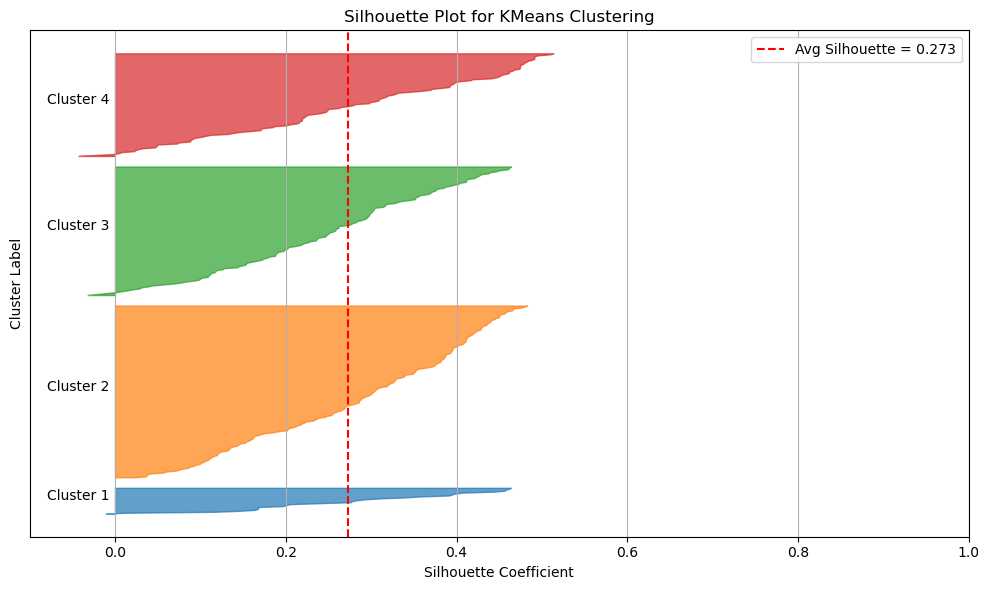

In [21]:
# Compute silhouette values for each sample
silhouette_vals = silhouette_samples(X_scaled, students_no_nan['cluster'])
cluster_labels = students_no_nan['cluster']

# Compute cluster order based on decreasing median_score
cluster_medians = students_no_nan.groupby('cluster')['median_score'].median()
sorted_cluster_ids = cluster_medians.sort_values(ascending=False).index.tolist()

# Plotting setup
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10  # starting y position

for i, cluster_id in enumerate(sorted_cluster_ids):
    # Get silhouette scores for samples in cluster_id
    ith_cluster_sil_vals = silhouette_vals[cluster_labels == cluster_id]
    ith_cluster_sil_vals.sort()

    size_cluster_i = ith_cluster_sil_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.tab10(i)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_sil_vals,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )
    ax.text(-0.08, y_lower + 0.5 * size_cluster_i, f"Cluster {i+1}")
    y_lower = y_upper + 10  # spacing between clusters

# Average silhouette score line
avg_score = silhouette_score(X_scaled, cluster_labels)
ax.axvline(avg_score, color="red", linestyle="--", label=f"Avg Silhouette = {avg_score:.3f}")

# Labels and formatting
ax.set_title("Silhouette Plot for KMeans Clustering")
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster Label")
ax.set_yticks([])
ax.set_xlim([-0.1, 1])
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


**Discussion:**

The average silhouette score is **0.273**, indicating that the overall clustering structure is relatively weak. Many samples are not well-separated from neighboring clusters, and Cluster 1, in particular, shows very low silhouette values. This aligns with our profile interpretation table, where Cluster 1 is a small group with only **28** students, unlike the larger, more stable clusters. Interestingly, from our profile interpretation table, Cluster 1 and Cluster 2 share similar characteristics and could potentially be merged based on our profile analysis (even though the elbow method suggested 4 clusters).

In contrast, other clusters show better cohesion, with silhouette values concentrated around **0.3–0.4**, indicating clearer internal structure.

That said, the modest clustering performance may be attributed to the lack of richness in the data. With only 5 features used to cluster approximately 450 students, the model may suffer from the curse of dimensionality, where the feature space becomes sparse and distances between points lose meaning.

Nevertheless, the analysis successfully revealed distinct user profiles and allowed us to compare their performance in terms of median scores. This, in turn, provided valuable insights into the factors that may influence academic success, highlighting meaningful patterns and differences across student profiles.

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*